In [31]:
import pandas as pd
import numpy as np
# from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier

AttributeError: type object '_catboost._FloatArrayWrapper' has no attribute '__reduce_cython__'

In [28]:
# 读取数据
train = pd.read_csv('first_round_training_data.csv')
test = pd.read_csv('first_round_testing_data.csv')

In [3]:
# 特征列表
features = ["Parameter1","Parameter2","Parameter3","Parameter4","Parameter5","Parameter6","Parameter7","Parameter8","Parameter9","Parameter10"]
features_less = ["Parameter5","Parameter6","Parameter7","Parameter8","Parameter9","Parameter10"]
features_unimportant = ["Parameter1","Parameter2","Parameter3","Parameter4"]

In [4]:
# 标签转化
def quality_encoder(x):
    return {'Excellent':0,'Good':1,'Pass':2,'Fail':3}[x]

train['label'] = train.Quality_label.apply(quality_encoder)
train['label_Excellent'] = 1*(train['label'] == 0)
train['label_Good'] = 1*(train['label'] == 1)
train['label_Pass'] = 1*(train['label'] == 2)
train['label_Fail'] = 1*(train['label'] == 3)

In [5]:
print(train['label_Excellent'].sum())
print(train['label_Good'] .sum())
print(train['label_Pass'] .sum())
print(train['label_Fail'].sum())

1107
1584
2417
892


## My EDA

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### label distribution

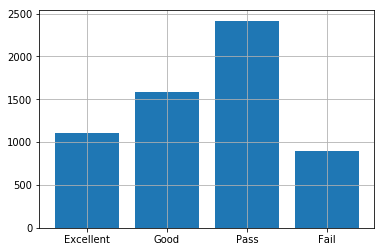

In [18]:
names=["Excellent","Good","Pass","Fail"]
nums=[sum(train['label']==x) for x in range(4)]
plt.bar(names,nums)
plt.grid()

### Correlation

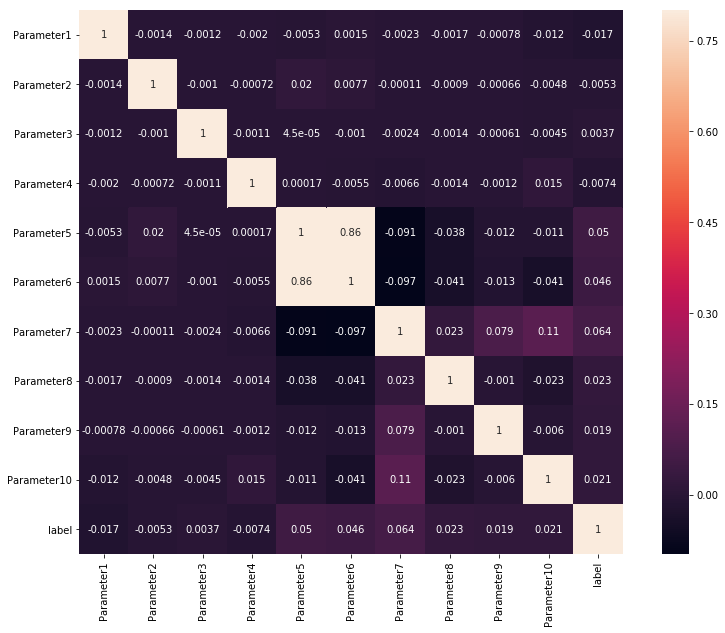

In [26]:
train_raw=train.loc[:,features+["label"]]
correlation_matrix = train_raw.corr()
plt.figure(figsize=(14,10))
sns.heatmap(correlation_matrix, annot = True,vmax=0.8, square=True)

In [74]:
# 本地多分类准确率评估
local_train = train.iloc[:5000,:].copy()
local_valid = train.iloc[5000:,:].copy()

model = GradientBoostingClassifier(max_depth=3,learning_rate=0.1,n_estimators=100,random_state=666)
model.fit(local_train.loc[:,features],local_train.label)

local_valid['prediction'] = model.predict(local_valid.loc[:,features])
(local_valid.label == local_valid.prediction).mean()

0.472

In [75]:
# 线上提交
model = GradientBoostingClassifier(max_depth=3,learning_rate=0.1,n_estimators=100,random_state=666)
model.fit(train.loc[:,features],train.label)

test['prediction'] = model.predict(test.loc[:,features])
test['prob_Excellent'] = 0.0
test['prob_Good'] = 0.0
test['prob_Pass'] = 0.0
test['prob_Fail'] = 0.0
test.loc[:,['prob_Excellent','prob_Good','prob_Pass','prob_Fail']] = model.predict_proba(test.loc[:,features])

In [76]:
# 提交用
prediction = test.groupby(['Group'],as_index=False)['prob_Excellent','prob_Good','prob_Pass','prob_Fail'].mean()
prediction.columns = ['Group','Excellent ratio','Good ratio','Pass ratio','Fail ratio']
prediction.to_csv('baseline.csv',index=False)

## 五折交叉验证

In [11]:
cv_preds=[]
batch=int(len(train_norm)/5)
for i in range(5):
    cv_start=batch*i
    cv_end=batch*(i+1)
    split_cv=train_norm.iloc[cv_start:cv_end,:].copy()
    split_train=train_norm.iloc[0:cv_start,:].copy().append(train_norm.iloc[cv_end:,:].copy())
#     model = GradientBoostingClassifier(max_depth=3,learning_rate=0.1,n_estimators=90,random_state=555)
    model = CatBoostClassifier(iterations=2000,depth=8,learning_rate=0.01,verbose=100,loss_function='MultiClass',random_state=666)
    model.fit(split_train.loc[:,features_less],split_train.label)
    split_cv['pred']=model.predict(split_cv.loc[:,features_less])
    cv_preds.append((split_cv['pred']==split_cv['label']).mean())
    print("mean value of cv "+ str(i)+" is " +str(cv_preds[i]))
    
print("cross validation prob is "+ str(np.mean(np.array(cv_preds))))
    
    

mean value of cv 0 is 0.5098039215686274
mean value of cv 1 is 0.5527544351073763
mean value of cv 2 is 0.5331465919701214
mean value of cv 3 is 0.5546218487394958
mean value of cv 4 is 0.5032679738562091
cross validation prob is 0.5307189542483661


In [21]:
# 提交用
test_norm['Group']=test['Group']
test_norm['prediction'] = model.predict(test_norm.loc[:,features_less])
test_norm['prob_Excellent'] = 0.0
test_norm['prob_Good'] = 0.0
test_norm['prob_Pass'] = 0.0
test_norm['prob_Fail'] = 0.0
test_norm.loc[:,['prob_Excellent','prob_Good','prob_Pass','prob_Fail']] = model.predict_proba(test_norm.loc[:,features_less])
prediction_norm = test_norm.groupby(['Group'],as_index=False)['prob_Excellent','prob_Good','prob_Pass','prob_Fail'].mean()
prediction_norm.columns = ['Group','Excellent ratio','Good ratio','Pass ratio','Fail ratio']
prediction_norm.to_csv('baseline64_norm.csv',index=False)

In [20]:
test_norm.tail(20)


,Parameter1,Parameter2,Parameter3,Parameter4,Parameter5,Parameter6,Parameter7,Parameter8,Parameter9,Parameter10,prediction,prob_Excellent,prob_Good,prob_Pass,prob_Fail,Group
5979,-0.000663,-0.001212,-0.000564,-0.000224,-0.078916,-0.140615,0.059420,-0.000979,-0.000566,-0.060337,2,0.231243,0.067601,0.604855,0.096301,119
5980,-0.000665,-0.001211,-0.000564,-0.000224,0.020542,-0.075461,-0.004630,-0.000713,-0.000566,-0.087155,1,0.068788,0.420858,0.148604,0.361751,119
5981,-0.000664,-0.001212,-0.000561,-0.000224,0.020542,0.114677,-0.004626,-0.000979,-0.000566,-0.049838,2,0.166136,0.120896,0.655101,0.057868,119
5982,-0.000664,-0.001211,-0.000563,-0.000224,0.044993,-0.023622,-0.004626,-0.000833,-0.000566,-0.086973,1,0.046699,0.568938,0.097420,0.286943,119
5983,-0.000665,-0.001183,-0.000491,-0.000224,-0.014839,-0.044359,-0.004630,-0.000713,-0.000566,-0.087155,3,0.054088,0.274787,0.284124,0.387000,119
5985,-0.000665,-0.001212,-0.000564,-0.000224,-0.059793,-0.061421,-0.004614,-0.000713,-0.000566,-0.086826,2,0.090223,0.309077,0.402086,0.198614,119
5986,-0.000665,-0.001212,-0.000563,-0.000224,-0.014839,0.114677,-0.004626,-0.000979,-0.000566,-0.067898,2,0.137036,0.115625,0.686810,0.060529,119
5987,-0.000665,-0.001209,-0.000564,-0.000224,0.059389,0.114677,-0.004626,-0.000979,-0.000566,-0.035260,2,0.197663,0.133961,0.610322,0.058054,119
5988,-0.000665,-0.001211,-0.000564,-0.000224,-0.007395,-0.136405,-0.004614,-0.000713,-0.000566,-0.086973,1,0.106608,0.477787,0.238946,0.176659,119
5989,-0.000665,-0.001212,-0.000563,-0.000224,-0.041932,-0.096517,-0.004614,-0.000713,-0.000566,-0.085398,2,0.075476,0.289567,0.464121,0.170836,119


### outliers

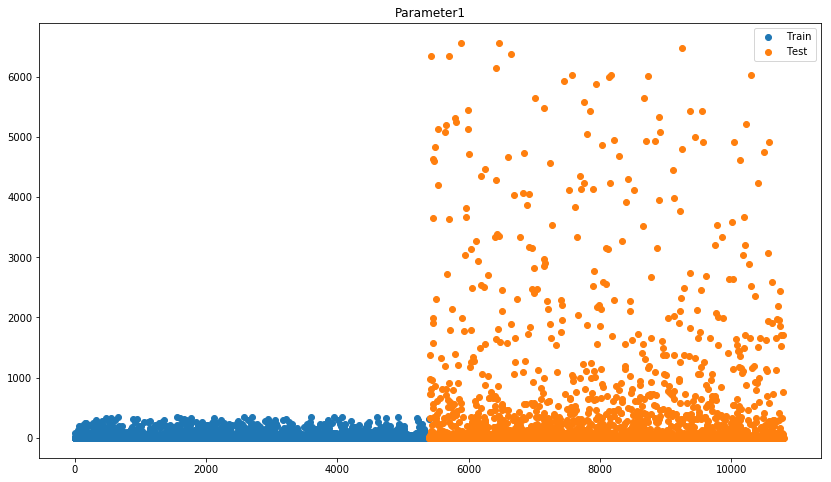

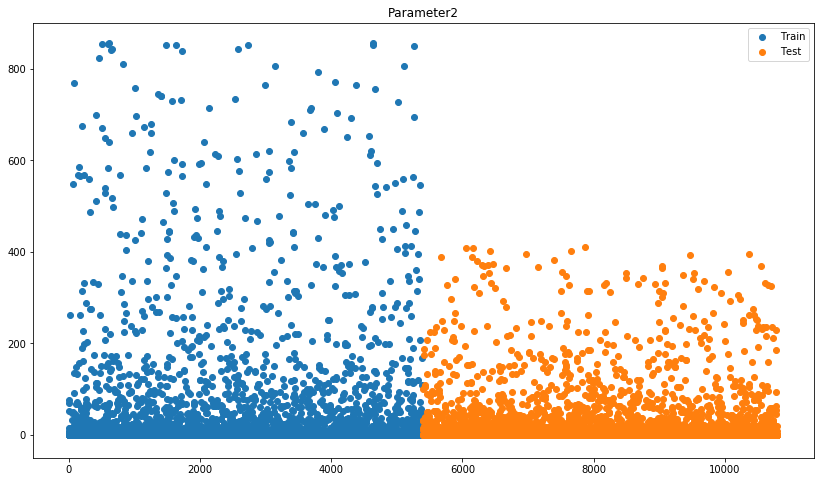

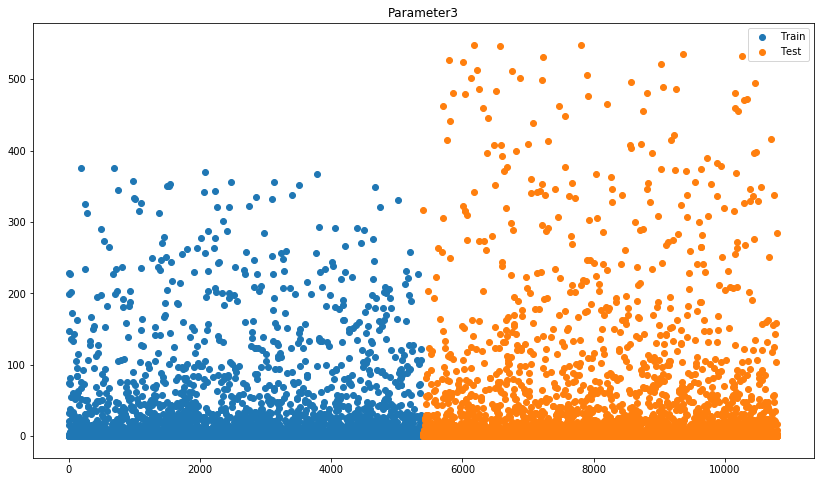

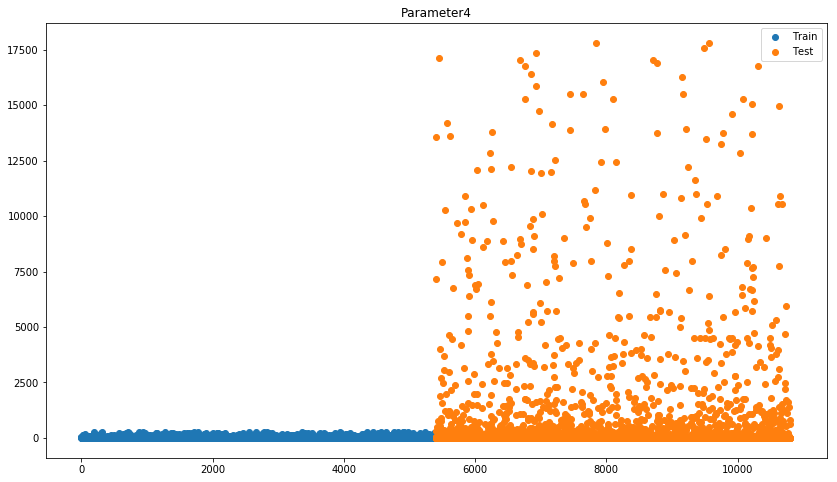

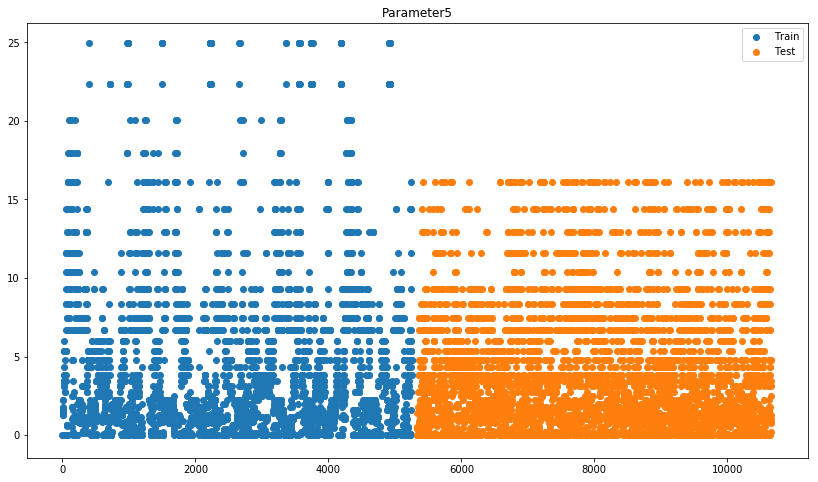

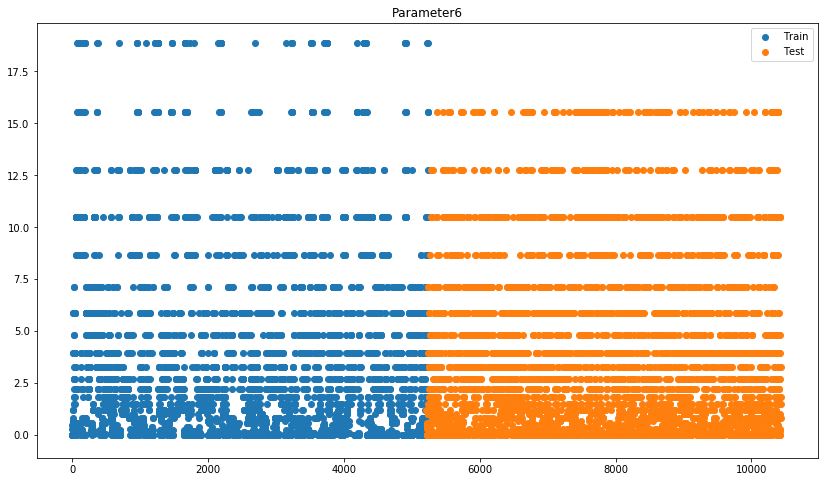

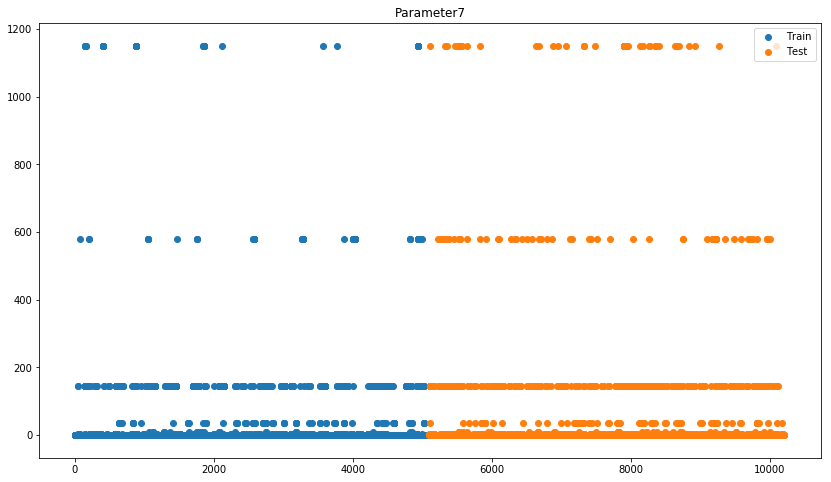

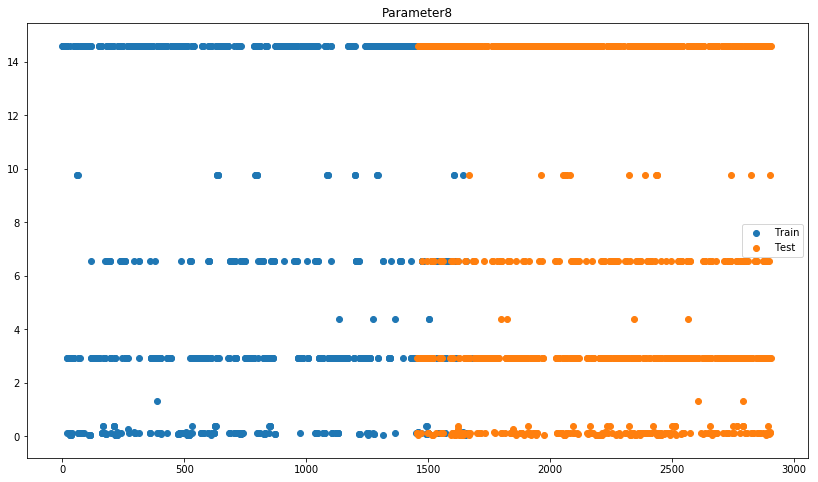

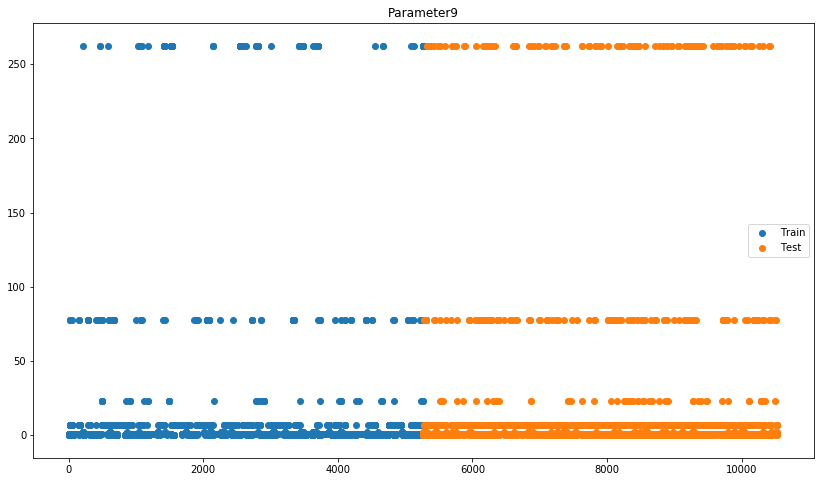

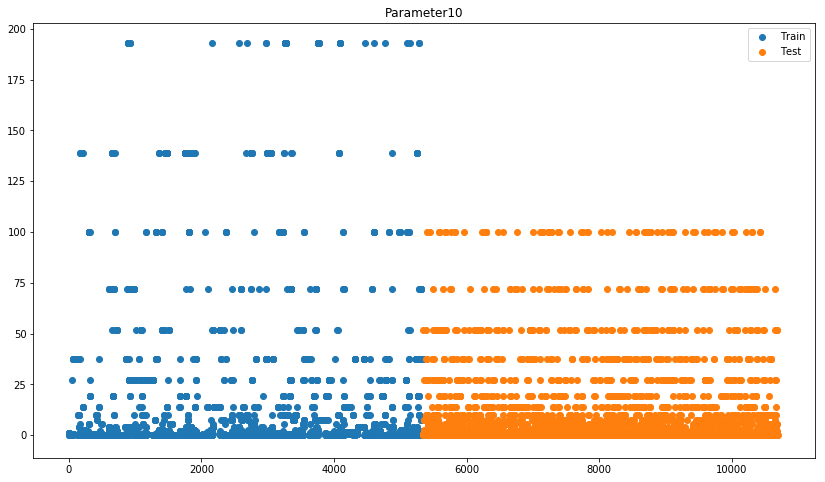

In [8]:
for i in ['Parameter'+str(i) for i in range(1,11)]:
    upper_train=train[i].quantile(.95)
    lower_train=train[i].quantile(.05)
    train_rmo=train[(train[i]<upper_train)&(train[i]>lower_train)]
    upper_test=test[i].quantile(.95)
    lower_test=test[i].quantile(.05)
    test_rmo=test[(test[i]<upper_test)&(test[i]>lower_test)]
    plt.figure(figsize=(14,8))
    plt.scatter(x=range(len(train_rmo)), y=train_rmo[i], label='Train')
    plt.scatter(x=range(len(test_rmo),len(test_rmo)*2), y=test_rmo[i], label='Test')
    plt.title(i)
    plt.legend()
    plt.show()

In [9]:
print(train_rmo['label_Excellent'].sum())
print(train_rmo['label_Good'] .sum())
print(train_rmo['label_Pass'] .sum())
print(train_rmo['label_Fail'].sum())

1043
1350
2300
665


### log transform

In [41]:
train_log=train_rmo[features].apply(lambda x:np.log(x))
train_log['label']=train_rmo.label

### normalize

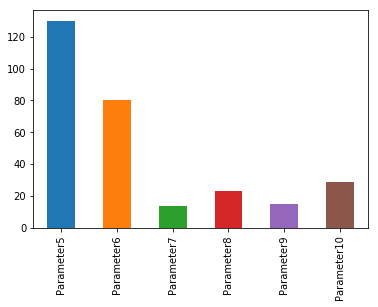

In [10]:
train_norm=train_rmo[features].apply(lambda x:(x - np.mean(x)) / (np.max(x) - np.min(x)))
train_norm['label']=train_rmo.label
test_norm=test_rmo[features].apply(lambda x:(x - np.mean(x)) / (np.max(x) - np.min(x)))
train_norm[features_less].nunique().plot(kind='bar')

### binning

In [73]:
for i in [i for i in range(1,5)]:
    maxb=train_rmo['Parameter'+str(i)].max()
    minb=train_rmo['Parameter'+str(i)].min()
    print("max"+str(maxb)+"; min"+str(minb))
    train_rmo['bin'+str(i)] = pd.cut(train_rmo['Parameter'+str(i)], bins=[minb,minb+(maxb-minb)/3,minb+(maxb-minb)/3*2,maxb], labels=[0, 1, 2])

max713682.207600978; min2.9839547347619007e-06
max3034567.779111118; min1.6837967588692046e-07
max864530.6321788637; min5.043727888195611e-06
max139767.49473188038; min5.387062256531668e-06


D:\CV_ENV\envs\cyz_py3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### feature mean encoding

In [96]:
for col in features_less:
#     means= train_rmo.groupby(col).label.mean()
    train_rmo[col+'_mean_target'] = train_rmo[col].map(train_rmo.groupby(col).label.mean())
#     val_new[col+'_mean_target'] = val_new[col].map(means)

D:\CV_ENV\envs\cyz_py3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
